In [23]:
do_simulate = False
include_wrapper = False
run_zero_signal_test = False
if run_zero_signal_test:
    include_wrapper = False
    use_zeros_data = True
else:
    use_zeros_data = False

In [24]:
import matplotlib.pyplot as plt
import neurokit2 as nk
import importlib  # for re-loading packages
import numpy as np

# Use your detector
from neurokit2.ecg.ecg_findpeaks import _ecg_findpeaks_khamis

In [25]:
if do_simulate:
    fs = 500
    ecg_signal = nk.ecg_simulate(duration=10, sampling_rate=fs)
elif use_zeros_data:
    ecg_signal = np.zeros(12*240)
    fs=240
else:
    import scipy.io
    matlab_file_path = '/Users/petercharlton/Downloads/new_downloads/MIMIC_PERform_1_min_normal.mat'
    mat_data = scipy.io.loadmat(matlab_file_path)  # Replace with your file path

    # Access the ECG signal and sampling frequency from the 'data' structure
    ecg_signal = mat_data['data']['ekg'][0,0]['v'][0][0]  # 'v' contains the ECG signal
    ecg_signal = np.array(list(ecg_signal.T[0]))
    fs = int(mat_data['data']['ekg'][0,0]['fs'][0][0][0][0])  # 'fs' contains the sampling frequency

In [26]:
if include_wrapper:
    signals, info = nk.ecg_peaks(ecg_signal, sampling_rate=fs, method='khamis2016', correct_artifacts=False, show=False)
    rpeaks = signals['ECG_R_Peaks']
    rpeaks = np.where(rpeaks == 1)[0]
else:
    rpeaks = _ecg_findpeaks_khamis(signal=ecg_signal, sampling_rate=fs)

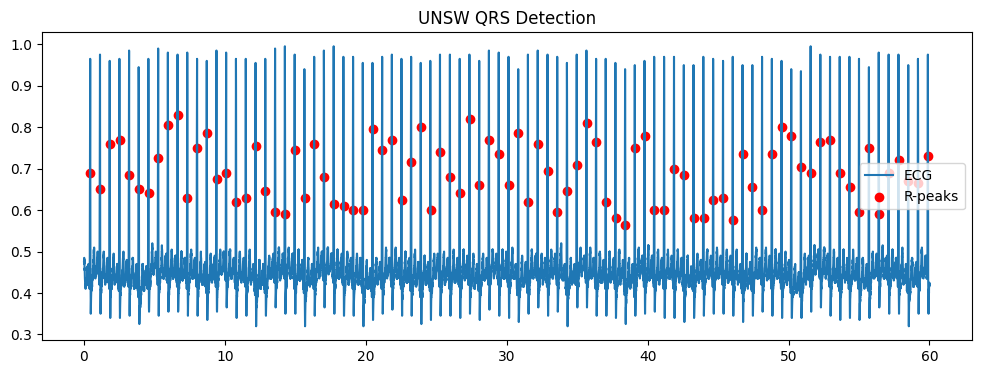

In [27]:
# Plot ECG and detected peaks
time = np.arange(len(ecg_signal)) / fs
plt.figure(figsize=(12, 4))
plt.plot(time, ecg_signal, label="ECG")
plt.scatter(time[rpeaks], ecg_signal[rpeaks], c='red', label="R-peaks")
plt.legend()
plt.title("UNSW QRS Detection")
#plt.xlim([0, 10])
plt.show()

Test

In [28]:
# from tests_ecg.py

sampling_rate = 1000

ecg = nk.ecg_simulate(
        duration=60,
        sampling_rate=sampling_rate,
        noise=0,
        method="simple",
        random_state=42,
    )

ecg_cleaned = nk.ecg_clean(ecg, sampling_rate=sampling_rate, method="neurokit")

# Test khamis2016 method
#info_khamis = nk.ecg_findpeaks(ecg_cleaned, sampling_rate=sampling_rate, method="christov2004")
info_khamis = nk.ecg_findpeaks(ecg_cleaned, sampling_rate=sampling_rate, method="khamis2016")
print(info_khamis["ECG_R_Peaks"].size)
#assert info_khamis["ECG_R_Peaks"].size == 273

69


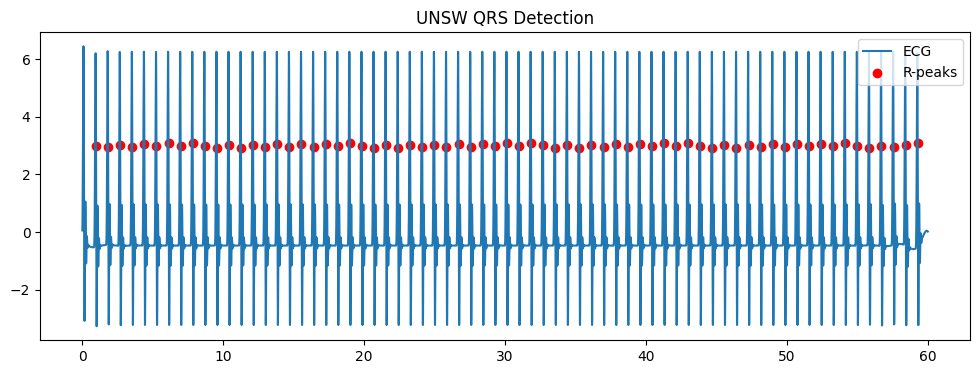

In [29]:
rpeaks2 = info_khamis["ECG_R_Peaks"]
time2 = np.arange(len(ecg_cleaned)) / sampling_rate
plt.figure(figsize=(12, 4))
plt.plot(time2, ecg_cleaned, label="ECG")
plt.scatter(time2[rpeaks2], ecg_cleaned[rpeaks2], c='red', label="R-peaks")
plt.legend()
plt.title("UNSW QRS Detection")
#plt.xlim([0, 20])
plt.show()

In [30]:
def cleansignal(x, fs):
        # cleansignal
        # Helper function:
        # baseline removal then high pass (0.7 Hz) filtering
        # followed by low pass (20 Hz) filtering

        x = scipy.signal.detrend(x)
        x = x.ravel()  # reshape so that it is the same dimension as baseline

        # Remove baseline
        baseline = sortfilt1(x, round(0.5 * fs), 50)
        meddata = x - baseline
        
        # here, we removed the hard-coded FIR filter coefficients (and LP filter order 7), and instead calculate filter
        # coefficients. In the original implementation hard-coded FIR filter coefficients (with LP filter order 7) were used
        # for sampling frequencies between 400 and 600 Hz, whereas they were calculated for sampling frequencies outside this
        # range (with LP filter order 8).

        # hpf - used to eliminate dc component or low frequency drift.
        sos = scipy.signal.butter(7, 0.7 / (fs / 2), btype='high', output='sos')
        hpdata = scipy.signal.sosfiltfilt(sos, meddata)
        #b, a = scipy.signal.butter(7, 0.7 / (fs / 2), btype='high')
        #hpdata = myfiltfilt(b, a, meddata)

        # low pass linear phase filter
        b, a = scipy.signal.butter(7, 20 / (fs / 2), btype='low')
        lphpdata = myfiltfilt(b, a, hpdata)

        return lphpdata

def sortfilt1(x, n, p):

        N = len(x)

        if p > 100:
            p = 100
        elif p < 0:
            p = 0

        if n % 2 == 0:
            N1 = int((n / 2) - 1)
            N2 = int((n / 2))
        else:
            N1 = int((n - 1) / 2)
            N2 = int((n - 1) / 2)

        y = np.zeros_like(x)

        y = np.zeros(N)
        for i in range(1, N + 1):
            A = max(1, i - N1)
            B = min(N, i + N2)
            P = 1 + round((p / 100) * (B - A))
            Z = np.sort(x[A - 1:B])
            y[i - 1] = Z[P - 1]

        return y

def myfiltfilt(b, a, x):

        if len(x) <= 3 * max([len(b) - 1, len(a) - 1]):
            y = np.zeros_like(x)
        else:
            y = scipy.signal.filtfilt(b, a, x)

        return y

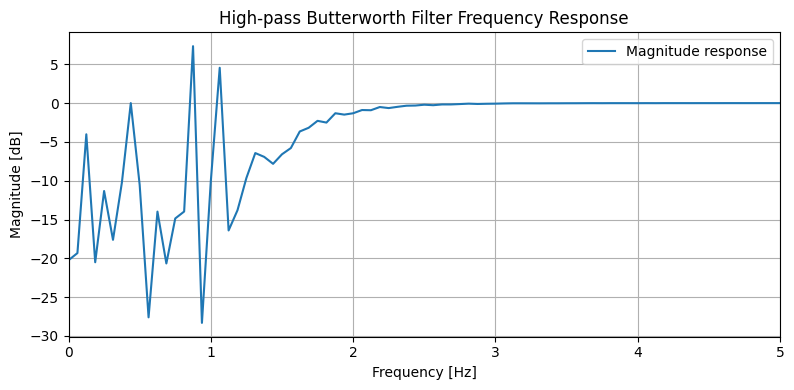

In [31]:
from scipy import signal

# Example parameters
fs = sampling_rate
b, a = signal.butter(7, 0.7 / (fs / 2), btype='high')  # 7th order high-pass filter

# Frequency response
w, h = signal.freqz(b, a, worN=8000)
frequencies = w * fs / (2 * np.pi)  # Convert from rad/sample to Hz

# Plot magnitude response
plt.figure(figsize=(8, 4))
plt.plot(frequencies, 20 * np.log10(abs(h)), label='Magnitude response')
plt.title('High-pass Butterworth Filter Frequency Response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xlim(0,5)
plt.show()

In [32]:
lphpdata = cleansignal(ecg_cleaned, sampling_rate)

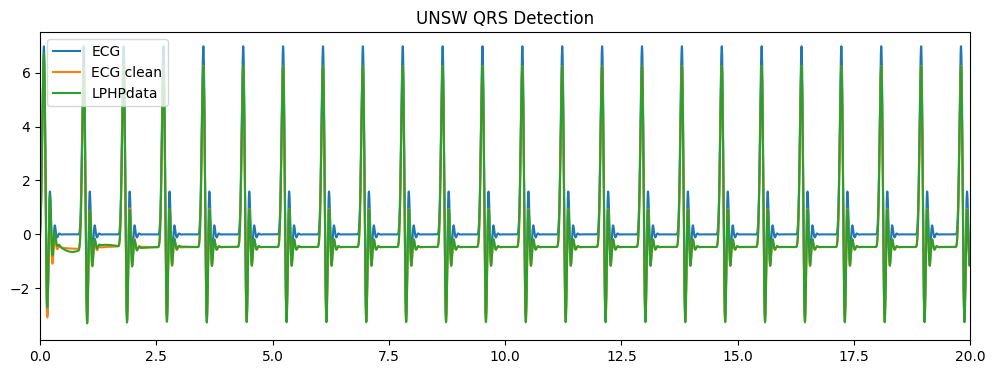

In [33]:
time2 = np.arange(len(ecg_cleaned)) / sampling_rate
plt.figure(figsize=(12, 4))
plt.plot(time2, ecg, label="ECG")
plt.plot(time2, ecg_cleaned, label="ECG clean")
plt.plot(time2, lphpdata, label="LPHPdata")
plt.legend()
plt.title("UNSW QRS Detection")
plt.xlim([0, 20])
plt.show()